# ESM1 Plotting
The purpose of this notebook is to access the CMIP6 data sets and present the ESM1 temperature data from historic simulations. Dask functionality has been added to improve speed of calculations, and functions have been implements to reduce the number of cells that require running for different dates.

//Todo:<br>
StartTimeFull and EndTimeFull should be identifed from data set, not predefined<br>
timeR should be removed and rangeSoloDateCalc + rangeAllDateCalc should be implemented<br>
worker memory error requires investigation<br>
further development of visualisation date and plots to be drawn<br>
<br>

#### Dask Import

<br>

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37189")
client

Client Scheduler: tcp://127.0.0.1:37189 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 9 Cores: 9 Memory: 57.98 GB


#### Choices for data

In [2]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceID = 'E3SM-1-0'

#Ocean Area data for averaging 
areaVariableId = 'areacello'
areaSourceId = 'CESM2'
areaDataSetNo = 0 #First database in results to be used

#Custom Variables
startTimeFull = '1850-01-16' #Start of full data set, included
endTimeFull = '2015-01-16' #End of full data set, excluded
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
timeR = slice('2012-01', '2015-01')

<br>

#### Imports

In [3]:
import cartopy.crs as ccrs
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm

<br>

#### Accessing Dataset Database

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

<br>

#### Filtering for relevant data sets
ESM3 data sets

In [5]:
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceID)]
print(str(len(dfFilt))+" datasets found.")
dfFilt

5 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
270827,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190826
271451,CMIP,E3SM-Project,E3SM-1-0,historical,r2i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190830
401325,CMIP,E3SM-Project,E3SM-1-0,historical,r3i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
401333,CMIP,E3SM-Project,E3SM-1-0,historical,r4i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
430599,CMIP,E3SM-Project,E3SM-1-0,historical,r5i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200429


Ocean area data to be used for averaging

In [6]:
dfArea = df[df.variable_id.eq(areaVariableId) & df.source_id.eq(areaSourceId)]
print(str(len(dfArea))+" datasets found.")
dfArea.head()

73 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
58575,CMIP,NCAR,CESM2,historical,r3i1p1f1,Ofx,areacello,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
58598,CMIP,NCAR,CESM2,historical,r3i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
58783,CMIP,NCAR,CESM2,historical,r1i1p1f1,Ofx,areacello,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
58785,CMIP,NCAR,CESM2,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
59076,CMIP,NCAR,CESM2,historical,r2i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308


<br>

#### Opening all datafiles
ESM3 data

In [7]:
fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)

Ocean Area data

In [8]:
dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[areaDataSetNo]), consolidated=True)
dataAreaRaw = dsArea.areacello

<br>

#### Combine data sets into one xarray

In [9]:
for i in range(fileCount):
    fileSetList[i]['time']=('time',np.arange(startTimeFull,endTimeFull,dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds',np.arange(startTimeFull,endTimeFull ,dtype='datetime64[M]'))
fileSet = xr.combine_nested(fileSetList, concat_dim='SetId')
#fileSet #Uncomment to see full data set

<br>

#### Selection of Data

In [10]:
dataFiltLatLev = fileSet.thetao.sel(lat=latSel, lev=5.0) #Selection of latitude and depth
dataFiltFull = dataFiltLatLev.reset_coords(drop=True) #Removes lev if single value
print("Selection Complete")
#dataFiltFull #Uncomment to see filtered data set

Selection Complete


<br>

#### Calculation
Functions: <br>
meanTemp - Calculates the Southern Ocean mean temperature for a given data set <br>
singleSoloDateCalc - Calculates and displays the Ocean temperature at all locations from a selected data set,  prints mean ocean temperature <br>
singleAllDateCalc - Calculates and displays the Ocean temperature at all locations from all data sets,  prints mean ocean temperature <br>
rangeSoloDateCalc - Calculates and displays the mean Ocean temperature as a line plot for a given time period from a selected data set <br>
rangeAllDateCalc - Calculates and displays the mean Ocean temperature as a line plot for a given time period from all data sets, can also show standard deviation for data <br>

Global Data: <br>
dataAreaSH - Ocean area data for the selected latitudes ([latSec](#Choices-for-data)), taken from first [areacello](#Accessing-Dataset-Database) database <br>
totalArea - The sum of all the area in dataAreaSH ([see above](#Calculation))

In [11]:
@delayed
def meanTemp(dataSet):
    '''Calculates and returns Mean Ocean temperature for a given data set. Requires global dataAreaSH, totalArea'''
    return (dataSet*dataAreaSH).sum(dim=['lon', 'lat']) / totalArea 

dataAreaSH = dataAreaRaw.sel(lat=latSel) #Selecting data for relevant latittude
totalArea = dataAreaSH.sum(dim=['lon', 'lat']) #Summing selected area

def singleSoloDateCalc(date,setId,plotNo):
    '''Calculates and displays Ocean temperature for a selected date, prints mean ocean temperature, uses only 1 data set. Requires global dataFiltFull, dataAreaSH, totalArea'''
    singleData = dataFiltFull.sel(SetId=setId, time=date)
    singleTemp = meanTemp(singleData)
    valuesSingleTemp = singleTemp.compute()
    singleTimePlot(singleData,date, valuesSingleTemp, setId, plotNo)
    
def singleAllDateCalc(date,plotNo):
    '''Calculates and displays Ocean temperature for a selected date, prints mean ocean temperature, averages all data sets. Requires global dataFiltFull, dataAreaSH, totalArea'''
    multiData = dataFiltFull.sel(time=date)
    multiTemps = meanTemp(multiData)
    valuesMultiTemps = multiTemps.compute()
    meanData = multiData.mean("SetId")
    valuesMeanTemp = valuesMultiTemps.mean("SetId")
    singleTimePlot(meanData, date, valuesMeanTemp, "All", plotNo)
    
def rangeSoloDateCalc(startDate, endDate, setId, plotNo):
    '''Calculates and displays Ocean temperature for a time period, prints mean ocean temperature, uses only 1 data set. Requires global dataFiltFull, dataAreaSH, totalArea'''
    multiData = dataFiltFull.sel(SetId=setId, time=slice(startDate, endDate))
    multiTemp = meanTemp(multiData)
    valuesMultiTemp = multiTemp.compute()
    multiTimePlot(valuesMultiTemp, startDate, endDate, setId, plotNo)

def rangeAllDateCalc(startDate, endDate, stdBool , plotNo):
    '''Calculates and displays Ocean temperature for a time period, prints mean ocean temperature, uses only 1 data set. Requires global dataFiltFull, dataAreaSH, totalArea'''
    multiDatas = dataFiltFull.sel(time=slice(startDate, endDate))
    multiTemps = meanTemp(multiDatas)
    valuesMultiTemps = multiTemps.compute()
    meanMultiTemp = valuesMultiTemps.mean("SetId")
    meanMultiTemp.compute()
    multiTimePlot(meanMultiTemp, startDate, endDate, 'All', plotNo)
    if stdBool:
        stdMultiTemp = valuesMultiTemps.std("SetId")
        stdMultiTemp.compute()
        multiTimePlotStd(stdMultiTemp, startDate, endDate, plotNo + 1)

<br>

#### Presentation of data
Functions: <br>
singleTimePlot - Displays the Ocean temperature at all locations from a given data set, prints mean ocean temperature. <br>
singleTimePlotStd - Displays the Ocean temperature standard deviation at all locations from a given data set, prints mean ocean temperature standard deviation. <br>
multiTimePlot - Displays the mean Ocean temperature from a given data set as a line plot <br>
multiTimePlotStd - Displays the standard deviation of Ocean temperature from a given data set as a line plot <br>

In [12]:
def singleTimePlot(dataSet, date, meanTempArray, setStr, plotNo):
    '''Displays Ocean temperature for given data set on a map, prints mean ocean temperature'''
    plt.figure(plotNo)
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),cmap='RdBu_r',robust=True,
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title("Southern Ocean Temp - " + str(date) + " ("+str(setStr)+")")
    print("Average Ocean temperature for plot "+str(plotNo)+" ("+date+")(Set "+str(setStr)+"): "+str(round(meanTempArray.values[0],2))+" Celsius")
    
def singleTimePlotStd(dataSet, date, stdTempArray, plotNo):
    '''Displays Ocean temperature standard deviation for given data set on a map, prints mean ocean temperature'''
    plt.figure(plotNo)
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),cmap='RdBu_r',robust=True,
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title("Southern Ocean Temp Std - " + str(date) + " ("+str(setStr)+")")
    print("Average Ocean temperature standard deviation for plot "+str(plotNo)+" ("+date+")(Set "+str(setStr)+"): "+str(round(stdTempArray.values[0],2))+" Celsius")
    
def multiTimePlot(dataSet, startDate, endDate, setStr, plotNo):
    '''Displays Ocean temperature for given data set as line graph'''
    plt.figure(plotNo)
    dataSet.plot(label='Monthly Mean')
    dataSet.rolling(time=12).mean().plot(label='12 month rolling mean')
    plt.legend()
    plt.title("Southern Ocean Temp - " + str(startDate)+" to "+str(endDate))
    
def multiTimePlotStd(dataSet, startDate, endDate, plotNo):
    '''Displays Ocean temperature standard devation for given data set as line graph'''
    plt.figure(plotNo)
    dataSet.plot(label='Monthly Std')
    plt.legend()
    plt.title("Southern Ocean Temp Deviation - " + str(startDate)+" to "+str(endDate)+" "+str(fileCount)+" datasets")

Demonstration data selection and Rectangular Plot

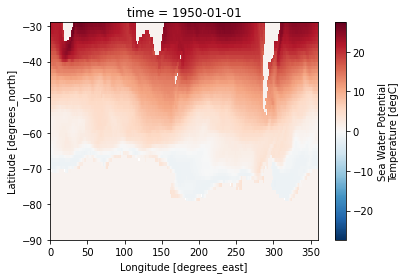

In [13]:
#Demo data to allow comparrison between open calculation and function singleSoloDateCalc
demoTime = '1950-01'
demoData = dataFiltFull.sel(SetId=0,time=demoTime)
demoMean = meanTemp(demoData)
valueDemoMean = demoMean.compute()
demoData.squeeze().plot()

Single time plot demonstration and comparisson of plotting vs calculation and plotting methods. Input parameters for the second method should match the demo data in the above cell.

Average Ocean temperature for plot 1 (1950-01)(Set 0): 10.11 Celsius
Average Ocean temperature for plot 2 (1950-01)(Set 0): 10.11 Celsius


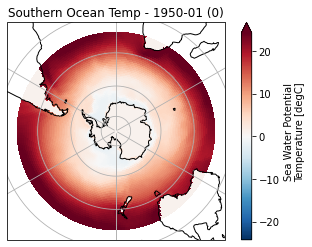

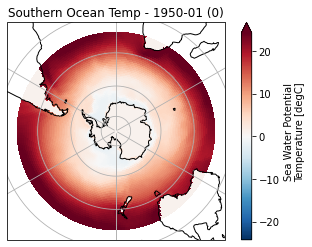

In [14]:
singleTimePlot(demoData, demoTime, valueDemoMean, 0, 1) #uses prior calculated demo data
singleSoloDateCalc(demoTime,0,2) #Recalculates all data

Demonstration of singleAllDateCalc, which takes all available data sets for the selected date and displays the mean result.

Average Ocean temperature for plot 1 (2014-01)(Set All): 10.6 Celsius


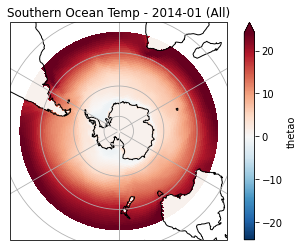

In [15]:
singleAllDateCalc('2014-01',1) #Calculates data in function

Demonstration of rangeSoloDateCalc, which takes a start date (included) and an end date (excluded) and displays the mean ocean temperature across the given time period for a selected data set.

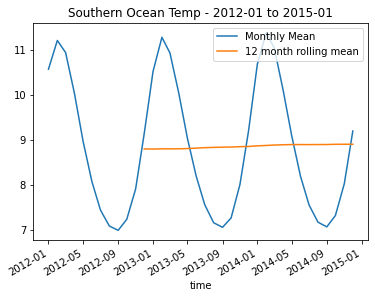

In [16]:
rangeSoloDateCalc('2012-01', '2015-01', 0, 2) #Calculates data in function

Demonstration of rangeAllDateCalc with a comparrison to manual calculation. The function takes a start date (included) and an end date (excluded) and displays the mean ocean temperature across the given time period for all available data sets. The standard deviation of the data can also be plotted.

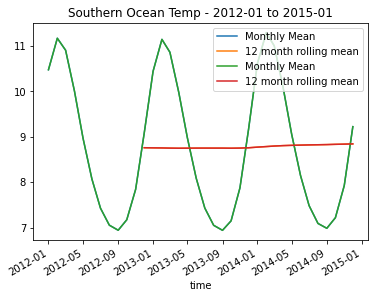

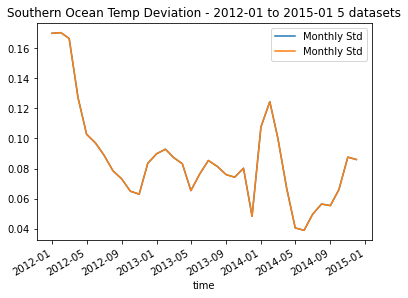

In [17]:
#Demo data to allow comparrison between open calculation and function rangeAllDateCalc
demoRangeData = dataFiltFull.sel(time=timeR)
demoRangeTemps = meanTemp(demoRangeData)
demoValuesRangeTemps = demoRangeTemps.compute()
demoMeanRangeTemps = demoValuesRangeTemps.mean('SetId')
demoStdRangeTemps = demoValuesRangeTemps.std('SetId')
demoMeanRangeTemps.compute()
demoStdRangeTemps.compute()
multiTimePlot(demoMeanRangeTemps, '2012-01', '2015-01', "All", 1) #Uses prior calculated demo data, mean plot
multiTimePlotStd(demoStdRangeTemps,'2012-01', '2015-01', 2) #Uses prior calculated demo data, std plot

rangeAllDateCalc('2012-01','2015-01', True, 1) #Recalculates all data